# Multiprocessing in Python

Introducción al uso de múltiples procesos en Python con la ayuda de la biblioteca de multiprocessing.

## Introducción teórica

### Processes y threads

- **Process** es un contexto de ejecución: instrucciones binarias, memoria, recursos.
- **Thread** en una unidad de ejecución, tiene procesador virtualizado.
- El proceso tiene al menos un hilo, puede tener muchos.
- Varios subprocesos comparten recursos en el contexto de un proceso.
- Los procesos se ejecutan en espacios de direcciones diferentes.


> **Nota importante:** ¡No hay subprocesos múltiples multinúcleo en Python!


### Processes y threads en Python
  

| Processes | Threads |
| ---------------------------------------------------------------------- | ---------------------------------------------------------------------- |
| - se puede ejecutar en paralelo en Python | - sólo se puede ejecutar simultáneamente en Python (GIL) - no multinúcleo |
| - espacio de memoria separado (fácil manejo, comunicaciones más difíciles - IPC) | - espacio de memoria compartida (gestión dura, comunicación sencilla) |
| - espacio de memoria más grande (generalmente utilizado en decenas - cientos) | - ligero (se puede utilizar en cientos - miles) |


**Los procesos son su única opción para utilizar múltiples núcleos y CPU en Python**


---------
> **Important note:** In notebooks use if __name__=='__main__': to wrap multiprocessing code, especially Pools.
> **Nota importante:** En notebooks use if __name __ == '__ main__': para envolver el código de multiprocessing, especialmente Pools.

## Uso básico de la biblioteca de multiprocessing
En este ejemplo, creamos dos procesos e intentamos operar en la misma lista dentro de ellos.

In [1]:
import multiprocessing as mp

def func(some_list):
  some_list.append("hello")
  print(some_list)

if __name__ == '__main__':
  some_list = ['first']

  p1 = mp.Process(target=func, args=(some_list, ))
  p2 = mp.Process(target=func, args=(some_list, ))

  p1.start()
  p2.start()

  p1.join()
  p2.join()

  print(some_list)

['first', 'hello']
['first', 'hello']
['first']


Como puede ver, los cambios realizados en la lista en los subprocesos no son visibles en el proceso principal. Este es el resultado del hecho de que la memoria se copia en la creación del nuevo proceso. Existen pocas técnicas para compartir información entre procesos.

Hagamos algo práctico antes de visitar otras funcionalidades de `multiprocessing`.

## Ejecutando una tarea para una lista de elementos

In [2]:
def same_thing(num):
    return num

if __name__ == '__main__':
    items = [1, 2, 3, 4, 5]
    processes = []
    for item in items:
        proc = mp.Process(target=same_thing, args=(item, ))
        proc.start()
        processes.append(proc)
    for proc in processes:
        proc.join()

## Multiprocessing pool - donde comienza la diversión!!
Permite una fácil descarga de tareas para 'worker processes'.

Funciones de mapa: mantiene el orden de los resultados devueltos. Si no lo necesita, use `imap_unordered` para la optimización. También puede ejecutar tareas de forma asincrónica con la ayuda de apply_async.

In [3]:
from time import sleep
import multiprocessing as mp

def f_sleep(x):
    sleep(2)
    return x*x


def f(x):
    return x*x


if __name__ == '__main__':
  
  with mp.Pool(processes=7) as pool:  # número predeterminado de procesos: os.cpu_count ()
    
    print(pool.map(f, range(10)))

    for i in pool.imap_unordered(f, range(10)):
        print(i)
        
    
    # ejecutar tareas de forma asincrónica
    tasks = []   
    
    for i in range(10):
        tasks.append(pool.apply_async(f_sleep, args=(i, )))
    
    # algún otro código

    # tiempo de espera si la obtención de resultados tarda demasiado
    for i in tasks:
        print(i.get(timeout=3))

  

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
0
1
4
9
25
16
36
64
49
81
0
1
4
9
16
25
36
49
64
81


## Performance - mandelbrot set
"Problema vergonzosamente paralelo". Vamos a echarle un vistazo para tener una prueba. Si no sabes que es mandelbrot te invito a que lo goolees :)

### Standard implementation

Completed in: 9.271976947784424 seconds


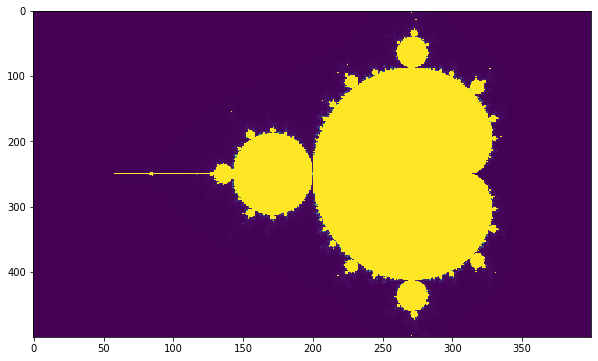

In [4]:
import matplotlib.pyplot as plt
from functools import partial
import time


def mandelbrotCalcRow(yPos, h, w, max_iteration = 1000):
    y0 = yPos * (2/float(h)) - 1 #cambiar la escala de -1 a 1
    row = []
    for xPos in range(w):
        x0 = xPos * (3.5/float(w)) - 2.5 #cambiar la escala de -2,5 a 1
        iteration, z = 0, 0 + 0j
        c = complex(x0, y0)
        while abs(z) < 2 and iteration < max_iteration:
            z = z**2 + c
            iteration += 1
        row.append(iteration)

    return row


def mandelbrotCalcSet(h, w, max_iteration = 1000):
    partialCalcRow = partial(mandelbrotCalcRow, h=h, w=w, max_iteration = max_iteration)
    mandelImg = list(map(partialCalcRow, range(h)))
    return mandelImg


if __name__ == '__main__':
    start_time = time.time()
    mandelImg = mandelbrotCalcSet(500, 400, 1000)
    print("Completed in: %s seconds" % (time.time() - start_time))
    
    plt.figure(figsize=(10, 6), facecolor='w', edgecolor='k')
plt.imshow(mandelImg,  interpolation='nearest', aspect='auto')

### Parallel implementation
Usemos un conjunto de procesos para clasificar filas en paralelo.

Completed in: 2.6731181144714355 seconds


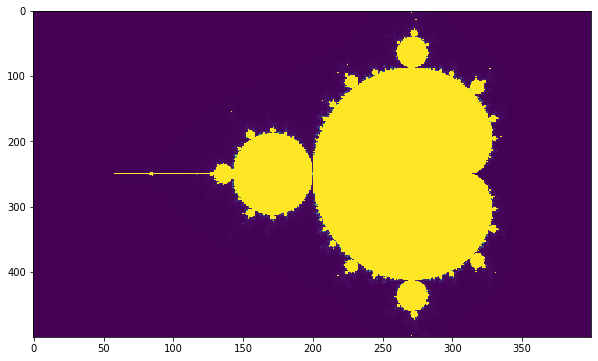

In [5]:
import multiprocessing as mp


def mandelbrotCalcSet(h, w, max_iteration = 1000):

    partialCalcRow = partial(mandelbrotCalcRow, h=h, w=w, max_iteration = max_iteration)
 
    pool = mp.Pool(processes=4)
    mandelImg = pool.map(partialCalcRow, range(h)) 
    pool.close()
    pool.join()
 
    return mandelImg


if __name__ == '__main__':
    start_time = time.time()
    mandelImg = mandelbrotCalcSet(500, 400, 1000)
    print("Completed in: %s seconds" % (time.time() - start_time))
    
    plt.figure(figsize=(10, 6), facecolor='w', edgecolor='k')
    plt.imshow(mandelImg,  interpolation='nearest', aspect='auto')

We were able to achieve a significant speed-up.

## Ejemplo práctico: lectura de csv grande, división, procesamiento
Un código como este se usó para procesar 300GB CSV en un proyecto real.

### Libs

In [6]:
import glob
import multiprocessing as mp
import os
import os.path
import pandas as pd

import pyarrow as pa
import pyarrow.parquet as pq

os.makedirs('in_dir', exist_ok=True)
os.makedirs('out_dir', exist_ok=True)

### Preprocesar el archivo
Divida el archivo de entrada en trozos. Chunksize debería ser más como 1e7.(1.0e7 significa 1 con 7 ceros. lo que significa 10,000,000.)

In [7]:
# definir las columnas
column_names = [
    'sepal_length', 'sepal_width', 'petal_length',
    'petal_width', 'class_name'
]

# pd.read_table admite, opcionalmente, iterar o dividir el archivo en trozos.
# obtenemos: Un archivo de valores separados por comas (csv) se devuelve como una estructura de datos bidimensional con ejes etiquetados.

reader = pd.read_table('iris.data.gz', chunksize=100,
                       names=column_names, compression='gzip')

for chunk_no, chunk in enumerate(reader):
# de lo que obtuvimos en el reader creamos los chunks en diferentes archivos dentro
# de la carpeta in_dir
    pq.write_table(
        pa.Table.from_pandas(chunk),
        os.path.join('in_dir', 'iris-{:04d}.parquet'.format(chunk_no)),
        compression='snappy'
    )

### Procesamiento en Paralelo

In [8]:
def do_work(filename):
    chunk = pq.read_table(filename).to_pandas()
    # procesando ...
    pq.write_table(pa.Table.from_pandas(chunk),
                   filename.replace('in', 'out'),
                   compression='snappy')

with mp.Pool() as pool:
    pool.map(do_work, glob.glob('in_dir/*.parquet'))

### Coleccionando los resultos

In [9]:
df = pq.read_table('out_dir').to_pandas()
# Agregue los resultados al informe final ...
df.to_csv('report.txt')

## Intercambio de datos entre procesos

### Pipes
- los objetos deben ser picklable
- bastante lento
- los objetos> 32 MB pueden causar errores
- la tubería es básicamente un búfer
- los datos pueden corromperse si los procesos escriben en el mismo extremo de la tubería al mismo tiempo
- implementado en el sistema operativo
- puede ser unidireccional o bidireccional

En este ejemplo, intentamos enviar datos del proceso hijo al proceso principal.

In [25]:
def func(conn):
    conn.send("Hi there, bud!")
    conn.close()
    

if __name__ == '__main__':

  one_end, second_end = mp.Pipe()

  for i in range(10):
      p = mp.Process(target=func, args=(second_end,))
      p.start()
      print(one_end.recv())
      p.join()

Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!


### Queue

- nivel más alto que las tuberías, más seguro
- puede almacenar objetos de Python
- lento


In [26]:
def func(results):
    results.put(["An answer is 42"])
    
if __name__ == '__main__':

  results = mp.Queue()

  p1 = mp.Process(target=func, args=(results, ))
  p1.start()
  p1.join()

  print(results.get())

['An answer is 42']


## Sincronizacion

Para ilustrar los mecanismos de sincronización, utilizamos la memoria compartida que se explica más adelante en este notebook.

### Ejemplo Trivial 

A veces queremos asegurarnos de que varios procesos no utilicen algunos recursos al mismo tiempo. En este ejemplo, los procesos están esperando que se libere el bloqueo para no confundir su salida.

Otros ejemplos: base de datos, archivos.

In [27]:
import multiprocessing as mp

def f(lock, i):
    lock.acquire()
    try:
        print('hello world', i)
    finally:
        lock.release()

if __name__ == '__main__':
    lock = mp.Lock()

    for num in range(2):
        mp.Process(target=f, args=(lock, num)).start()

hello world 0
hello world 1


## Compartiendo estado

En general, debe diseñar su software para evitar compartir memoria entre procesos. Si el caso de uso lo requiere, el multiprocesamiento proporciona una forma de compartir espacios de memoria.

### Memoria compartida

- usa una representación de memoria similar a c, solo hay matrices y valores.
- ver multiprocessing.csharedtypes para más
- ver recursos para usar con matrices numpy

In [13]:

def f(n, a, lock):
    lock.acquire()
    n.value = 3.1415927
    for i in range(len(a)):
        a[i] = -a[i]
    lock.release()

if __name__ == '__main__':
    num = mp.Value('d', 0.0)
    arr = mp.Array('i', range(10))
    lock = mp.Lock()

    p = mp.Process(target=f, args=(num, arr, lock))
    p.start()
    p.join()

    print(num.value)
    print(arr[:])

3.1415927
[0, -1, -2, -3, -4, -5, -6, -7, -8, -9]


### Por qué es importante Lock?

El acceso no supervisado a los recursos compartidos puede provocar un comportamiento inesperado, como el que se presenta a continuación. En teoría, deberíamos sumar 1 al valor de `num` 2000 veces, lo que da como resultado que` num` sea igual a 2000 y cambiar el signo de los elementos de la matriz` arr` 2000 veces, dejándolos positivos. Cuando ejecute la celda de abajo, debería notar que el valor `num` es más bajo y los elementos` arr` tienen diferentes signos. Consulte "Estado de intercambio" a continuación para obtener más información sobre las clases Value y Array.

In [14]:
import multiprocessing as mp


def f(n, a):
    n.value += 1;
    for i in range(len(a)):
        a[i] = -a[i]

        
if __name__ == '__main__':
    num = mp.Value('d', 0.0)
    arr = mp.Array('i', range(10))

    processes = []
    
    for i in range(1, 101):
        p = mp.Process(target=f, args=(num, arr))
        p.start()
        processes.append(p)

    for proc in processes:
        proc.join()

    print(num.value)
    print(arr[:])
    

100.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Proceso del servidor

Menos rendimiento, pero se puede utilizar con cualquier objeto pickable.


In [15]:
from multiprocessing import Process, Manager

def f(d, l):
    d[1] = '1'
    d['2'] = 2
    d[0.25] = None
    l.reverse()

if __name__ == '__main__':
    with Manager() as manager:
        d = manager.dict()
        l = manager.list(range(10))

        p = Process(target=f, args=(d, l))
        p.start()
        p.join()

        print(d)
        print(l)

{1: '1', '2': 2, 0.25: None}
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


## Resources
- Documentacion: [python docs](https://docs.python.org/3.6/library/multiprocessing.html)